In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

from nlbayes import ORNOR
from nlbayes.utils import gen_network, gen_evidence

In [2]:
net = network = gen_network(
        NX=125,      # total number of transcription factors
        NY=2500,     # total number of target genes
        AvgNTF=5,   # number of TFs that regulate a gene (average)
)

In [3]:
# randomly select 5 TFs as active
candidates = list(network.keys())
active_tfs = np.random.choice(candidates, size=5, replace=False)
active_tfs

array(['TF106', 'TF059', 'TF039', 'TF006', 'TF010'], dtype='<U5')

In [4]:
evd = evidence = gen_evidence(
        network=network,
        active_tfs=active_tfs,  # known set of active TFs. TFs with small regulon may not appear as active.
        tf_target_fraction=0.2, # only a fraction of a TF"s targets will become diff. expr.
)

ngtac=5, ndegs=190, nrels=12861


In [5]:
model = ORNOR(network, evidence, n_graphs=5, uniform_prior=False)
model.fit(n_samples=2000, gelman_rubin=1.1, burnin=True)


Initializing model burn-in ...



100%|██████████| 20/20 [00:00<00:00, 24.05it/s]


Converged after 20 samples
Max Gelman-Rubin statistic is 1.6797171517632505 (target was 5.0 )
Burn-in complete ...



100%|██████████| 170/170 [00:09<00:00, 18.21it/s]

Converged after 170 samples
Max Gelman-Rubin statistic is 1.096158857532597 (target was 1.1 )


In [6]:
df = results = model.get_results()

df["gt_act"] = df["TF_id"].isin(active_tfs)     # ground truth for active TFs
def fn(src):
    return len(network[src])
df["tot_trgs"] = df["TF_id"].apply(fn)              # total number of targets for each TF
def fn(src):
    return sum([evd.get(k, 0) != 0 for k in net[src].keys()])
df["dif_trgs"] = df["TF_id"].apply(fn)              # number of targets that are diff. expr.

df = df.iloc[:, [0, 4, 5, 3, 1, 2]]
df.sort_values(["gt_act", "X"], ascending=False).head(15) # show active TFs first

,TF_id,tot_trgs,dif_trgs,gt_act,X,T
rank,,,,,,
1,TF006,260,57,True,1.000000,0.933647
2,TF010,231,54,True,1.000000,0.899673
3,TF039,124,29,True,1.000000,0.915699
4,TF059,90,22,True,1.000000,0.874771
5,TF106,28,6,True,0.992647,0.776308
6,TF004,281,23,False,0.250000,0.520273
7,TF023,168,15,False,0.160294,0.526931
8,TF037,133,12,False,0.102941,0.505780
9,TF123,5,1,False,0.085294,0.515272


In [7]:
def plot_metric(method_name):
    curve = getattr(metrics, method_name)(df.gt_act, df.X)

    if method_name == "roc_curve":
        x, y = curve[:2]
        plt.plot((0,1), (0,1), c="gray", linestyle="--")
    if method_name == "precision_recall_curve":
        y, x = curve[:2]
        plt.plot((0,1), (1,0), c="gray", linestyle="--")
    
    auc = metrics.auc(x, y)
    plt.plot(x, y)
    plt.xlim(-.05,1.05)
    plt.ylim(-.05,1.05)
    plt.gca().set_aspect("equal")
    plt.grid(visible=True, which="major", color="lightgray", linestyle="-")
    plt.title(" ".join(method_name.split("_")) + f", {auc = :.4f}")
    plt.show()


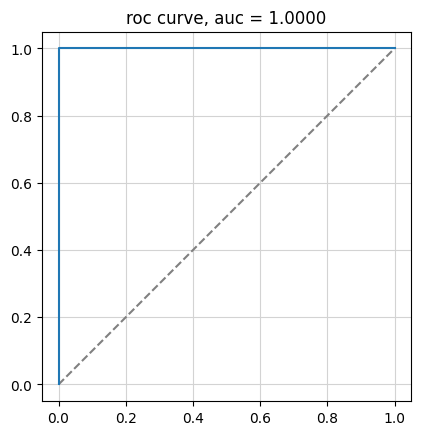

In [8]:
plot_metric("roc_curve")

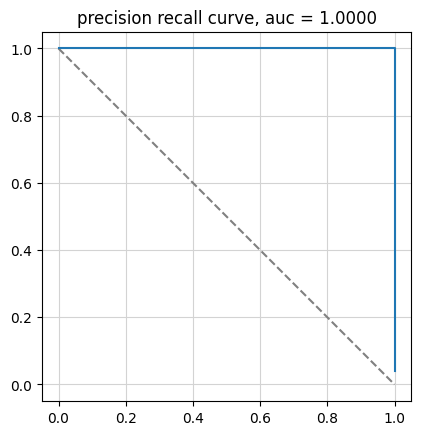

In [9]:
plot_metric("precision_recall_curve")